In [28]:
from operator import mul
from functools import reduce
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [7, 5]

In [29]:
boston = load_boston()
keys = list(boston.feature_names) + ['TARGET']
data = np.concatenate((boston.data, boston.target.reshape(-1,1)), axis=1)
data = normalize(data)

### Original Gaussian distribution

$$\mu = \dfrac{1}{m}\sum_{i=1}^{m}x^{(i)}$$


$$\sigma = \sqrt{\dfrac{1}{m}\sum_{i=1}^{m}\left(x^{(i)}-\mu\right)^{2}}$$


$$p\left(x;\mu;\sigma\right) = \dfrac{1}{\sigma\sqrt{2\pi}}\exp{\left(-\dfrac{(x-\mu)^{2}}{2\sigma^{2}}\right)}$$

### Multivariate Gaussian distribution

$$\mu_{j} = \dfrac{1}{m}\sum_{i=1}^{m}x^{(i)}_{j}$$

$$ \sum = \dfrac{1}{m}\sum_{i=1}^{m}\left(x^{(i)}-\mu\right)\left(x^{(i)}-\mu\right)^{T} $$

$$ p\left(x;\mu;\sum\right) = \dfrac{1}{\left(2\pi\right)^{0.5n}\det(\sum)^{0.5}}\exp{\left(-\dfrac{1}{2}(x-\mu)^{T}\sum^{-1}(x-\mu)\right)} $$

In [30]:
def p(x, mu, sigma):
    return ((sigma*(2*np.pi)**0.5)**-1) * np.exp(-(x-mu)**2/(2*sigma**2))

### Visualization 1D

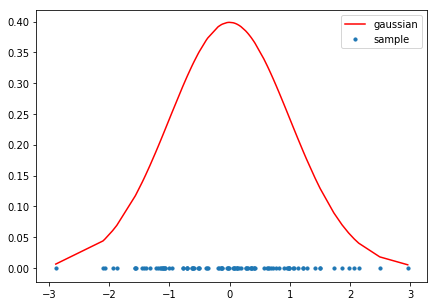

In [31]:
mu = 0
sigma = 1
x = np.random.normal(loc=mu, scale=sigma, size=(100,))
x = np.sort(x)
y = [p(x_i, mu, sigma) for x_i in x]
plt.plot(x, y, label='gaussian', c='red')
plt.scatter(x, [0]*len(x), label='sample', s=10)
plt.legend()
plt.show()

### Visualization 2D

Text(0.5,0,'Z axis')

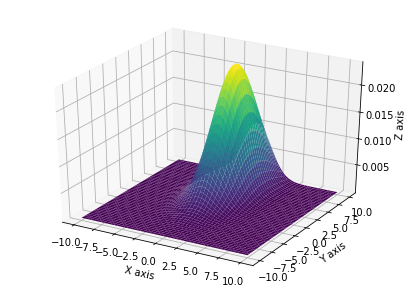

In [32]:
mu_x = 0
variance_x = 3
mu_y = 5
variance_y = 15

#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# plt.show()

In [84]:
class GausianModel(BaseEstimator, ClassifierMixin):
    """Implement anomaly detect model
    """
    def __init__(self, epsilon=None):
        self._epsilon = epsilon 
    
    def fit(self, X, y=None):
        m, n = X.shape
        self._mu = X.mean()
        delta = (X - self._mu)**2
        self._sigma = delta.mean(axis=0)**0.5
        self._epsilon = self._epsilon or 0.1**X.shape[1]

        return self
    
    def _p(self, x):
        return (sigma * (2*np.pi)**0.5)**-1 * (-((x-self._mu)**2)/((2*self._sigma)**2))
    
    def predict(self, X):
        labels = []
        for i, x_i in enumerate(X):
            p_i = self._p(x_i)
            p_i = reduce(mul, p_i, 1)
            if p_i < self._epsilon:
                labels.append(1)
            else:
                labels.append(0)
        return np.array(labels)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [93]:
class MultivariateGaussian(BaseEstimator, ClassifierMixin):
    def __init__(self, epsilon=None):
        self._epsilon = epsilon
        
    def fit(self, X, y=None):
        self._epsilon = self._epsilon or 0.1**X.shape[1]
        self._mu = X.mean(axis=0)
#         self._sigma = np.cov(X)
        delta = X - self._mu
        self._sigma = (1/len(X)) * delta.T.dot(delta)
        plt.imshow(self._sigma, cmap=plt.cm.Blues)
        plt.show()
    
    def predict(self, X):
        alpha = (2*np.pi)**(0.5*X.shape[1]) + np.linalg.det(self._sigma)**0.5
        beta = 0
    
    def score(self, X, y):
        pass

Training


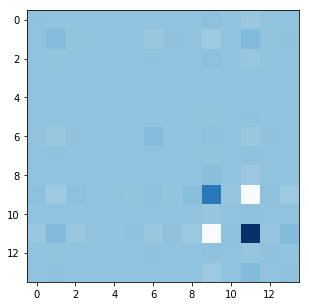

1.2404385892242308e-61
CPU times: user 160 ms, sys: 146 ms, total: 307 ms
Wall time: 119 ms
Predict
CPU times: user 22 µs, sys: 16 µs, total: 38 µs
Wall time: 7.87 µs
None


In [91]:
g = MultivariateGaussian(epsilon=None)
print('Training')
% time g.fit(data)
print('Predict')
%time label = g.predict(data)
print(label)